In [1]:
import os
import json
import openslide

import pandas
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt

import PySlide as pys

In [2]:
path = 'images/14.90610 C L2.11.json'
labels = {'GC':0}
file_type = 'json'
keys = ['GC']

In [3]:
ann=pys.Annotations(path, file_type)

In [4]:
annotations = ann.generate_annotations(labels)

### PySlide

In [5]:
slide = pys.Slide('images/14.90610 C L2.11.ndpi',border='draw',annotations=annotations)

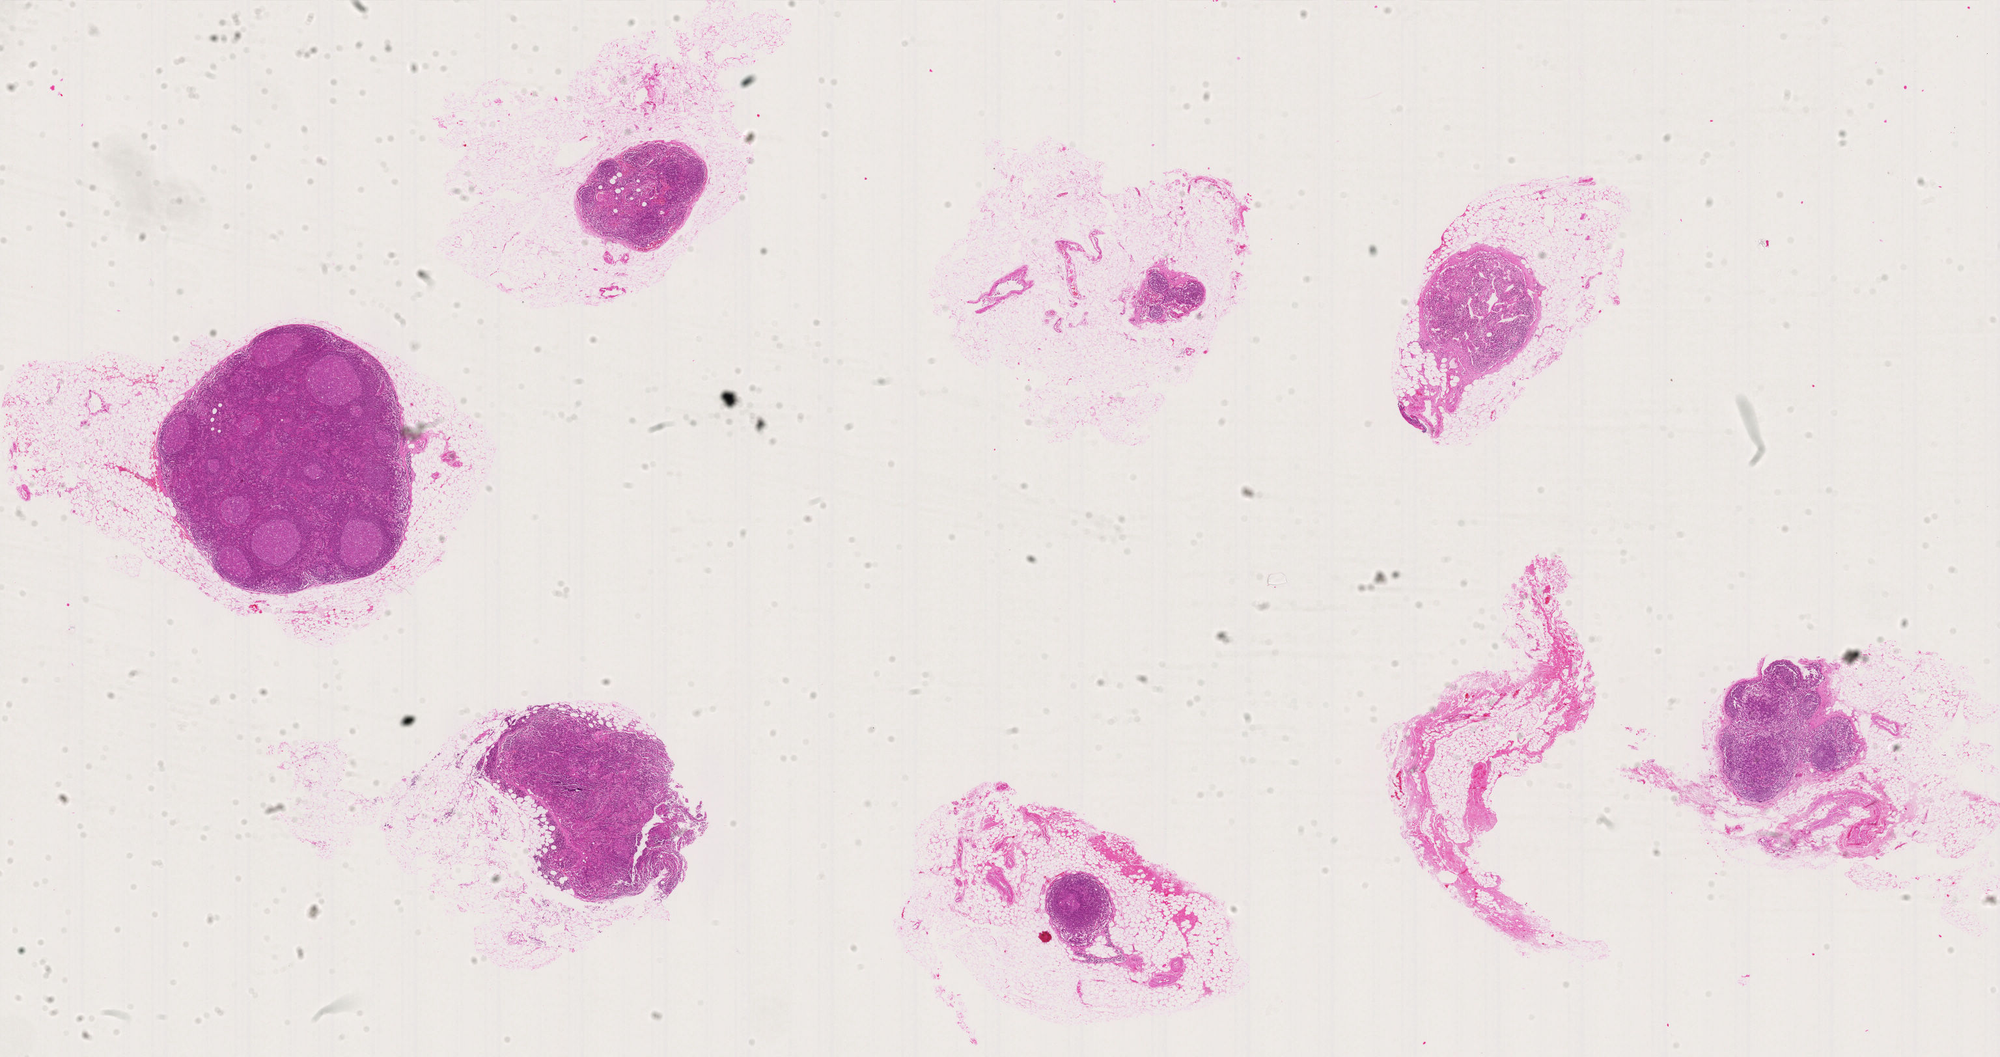

In [14]:
slide.get_thumbnail((2000,2000))

In [11]:
x = slide.slide_mask((2000,2000))

In [9]:
region, mask = slide.generate_region(mag=4, scale_border=True, factor=256)

x_size:768
y_size:768


In [12]:
slide.save()

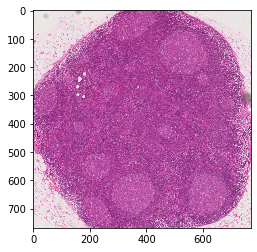

In [13]:
plt.imshow(region)